In [ ]:
!pip install -U albumentations
!pip install pytorch_model_summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import os.path as osp
import urllib.request
import zipfile
import tarfile

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler


import torchvision
from torchvision import datasets
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_model_summary

from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_model_summary
from tqdm import tqdm
import pdb
import random
import time

# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
CFG = {
    'IMG_SIZE':2048,
    'EPOCHS':30,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':12,
    'SEED':41,
    'DRIVE_PATH' : '/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/'
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

try:
    checkpoint = torch.load('/gdrive/MyDrive/pytorch-deeplearning/ch3 PSPNet/weight%d.pt' % 30)
    
except:
    checkpoint = {}

In [ ]:
train_dataset = datasets.FashionMNIST(root = './', train = True, transform = T.ToTensor(), download = True)
val_dataset = datasets.FashionMNIST(root = './', train = False, transform = T.ToTensor(), download = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
for t, l in train_dataloader:
    print(t.size(),l)
    break

torch.Size([128, 1, 28, 28]) tensor([4, 5, 4, 0, 4, 3, 4, 1, 8, 2, 4, 4, 5, 1, 1, 0, 2, 4, 9, 9, 8, 8, 4, 9,
        3, 5, 1, 3, 2, 2, 7, 9, 1, 4, 7, 7, 6, 8, 0, 9, 9, 2, 8, 6, 9, 5, 3, 2,
        0, 3, 1, 3, 0, 1, 0, 0, 5, 4, 0, 3, 6, 0, 7, 2, 0, 7, 5, 8, 9, 2, 5, 6,
        7, 4, 4, 5, 7, 7, 7, 5, 6, 6, 0, 7, 8, 3, 3, 9, 8, 4, 5, 2, 1, 3, 9, 2,
        3, 9, 2, 5, 4, 7, 0, 7, 5, 3, 6, 0, 7, 0, 8, 9, 1, 2, 6, 2, 1, 1, 8, 2,
        0, 3, 0, 9, 0, 7, 0, 3])


In [ ]:
from torch.autograd import profiler
from torch.profiler import profile, record_function, ProfilerActivity
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        # with profiler.record_function("LInear"):
        x = self.linear_relu_stack(x)
        
        return x 

In [ ]:
model = Net()
print(pytorch_model_summary.summary(model,torch.zeros(1,28,28), show_input=True, max_depth=None, show_parent_layers=True))

---------------------------------------------------------------------------------------
   Parent Layers       Layer (type)         Input Shape         Param #     Tr. Param #
             Net          Flatten-1         [1, 28, 28]               0               0
             Net           Linear-2            [1, 784]         401,920         401,920
             Net             ReLU-3            [1, 512]               0               0
             Net           Linear-4            [1, 512]         262,656         262,656
             Net             ReLU-5            [1, 512]               0               0
             Net           Linear-6            [1, 512]           5,130           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
---------------------------------------------------------------------------------------


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


Net(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
def train(data_loader, model, optimizer, loss_fn, epochs):
    model.train()
    autocast(enabled=True, dtype=torch.float16, cache_enabled=True)
    scaler = GradScaler()

    print(f'------------------------------')
    print(f'train start')

    for epoch in range(epochs):
        optimizer.zero_grad()
        train_loss = 0.0
        cnt = 0

        for image, label in tqdm(data_loader):

            image = image.to(device)
            label = label.to(device)

            with autocast():
                pred = model(image)
                loss = loss_fn(pred, label) 
                loss.backward()
            optimizer.step()
            cnt +=1

            if cnt == 60:
                break
        
            if cnt % 100 ==0 :
                print(f'------------------------------')
                print(f'Epoch : {epoch+1}, train_loss : {loss.item() : >7f}')
                print(f'------------------------------')

In [ ]:
epochs = 1
train(train_dataloader, model, optimizer, loss_fn, epochs)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


------------------------------
train start


 23%|██▎       | 107/469 [00:02<00:10, 35.91it/s]

------------------------------
Epoch : 1, train_loss : 2.493588
------------------------------


 43%|████▎     | 204/469 [00:06<00:10, 25.46it/s]

------------------------------
Epoch : 1, train_loss : 2.167167
------------------------------


 65%|██████▍   | 304/469 [00:09<00:04, 35.72it/s]

------------------------------
Epoch : 1, train_loss : 1.638185
------------------------------


 86%|████████▌ | 404/469 [00:12<00:01, 36.38it/s]

------------------------------
Epoch : 1, train_loss : 2.507597
------------------------------


100%|██████████| 469/469 [00:13<00:00, 33.93it/s]


In [ ]:
x, y = next(iter(train_dataloader))
# with profiler.profile(with_stack = True, profile_memory= True) as prof:
    # output = model(x)
# print(prof.key_averages(group_by_stack_n = 5).table(sort_by = 'self_cpu_time_total', row_limit = 5))

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities = [ProfilerActivity.CPU],
            my_schedule = schedule(
                warmup=1,
                active=3,
                repeat=2),
                record_shapes = True) as prof:

    with record_function('model_inference'):
        train(train_dataloader, model, optimizer, loss_fn, epochs)
print(prof.key_averages().table(sort_by = 'self_cpu_time_total', row_limit = 5))
prof.export_chrome_trace('trace.json')

NameError: ignored

In [ ]:
def test(data_loader, model, optimizer, loss_fn):
    model.eval()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    print(f'------------------------------')
    print(f'test start')

    test_loss = 0.0
    correct = 0.0
    cnt = 0
    with torch.no_grad():
        for image, label in tqdm(data_loader):

            image = image.to(device)
            label = label.to(device)

            pred = model(image)
            test_loss = loss_fn(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    index = label.data == pred.argmax(1)
    # pdb.set_trace()
    for i, v in enumerate(index):
        if not v :
            plt.imshow(image[i].squeeze(0),cmap = 'gray')
            plt.show()
            print(classes[label[i].data], classes[pred[i].argmax(0)])
            break


In [ ]:
classes = np.array(['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot'])

------------------------------
test start


100%|██████████| 469/469 [00:10<00:00, 46.15it/s]


Test Error: 
 Accuracy: 45.0%, Avg loss: 0.008243 



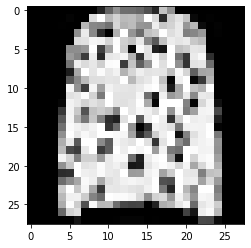

Shirt T-shirt/top


KeyboardInterrupt: ignored

In [ ]:
# from torch.profiler import profile, record_function, ProfilerActivity
# with profile(activities = [ProfilerActivity.CPU], record_shapes = True) as prof:
#     with record_function('model_inference'):
#         test(train_dataloader, model, optimizer, loss_fn)

# print(prof.key_averages().table(sort_by = 'cpu_time_total', row_limit = 5))

In [ ]:
X, y = next(iter(train_dataloader))
X, y

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [ ]:
pred = model(X)
(pred.argmax(1)==y).sum().item()

62